In [3]:
import pandas as pd
import pandas as pd
import numpy as np
import datetime
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import sklearn

# required machine learning packages
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

In [4]:
elo_all = pd.read_csv("nfl_elo.csv")
elo_all = elo_all.loc[elo_all['season'] >= 2005]
#elo_train = elo_all.loc[elo_all['season'] <= 2021]
elo_all = elo_all = elo_all.rename(columns={'team1': 'team_home_id', 'team2': 'team_away_id', 'date': 'schedule_date'})
elo_all

,schedule_date,season,neutral,playoff,team_home_id,team_away_id,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
12536,2005-09-08,2005,0,NaN,NE,OAK,1712.670000,1403.871000,0.895833,0.104167,...,179.265018,152.384786,89.853166,1655.718580,1449.365126,30,20,71.0,NaN,NaN
12537,2005-09-11,2005,0,NaN,CAR,NO,1530.111000,1506.978000,0.624181,0.375819,...,207.314012,122.751116,105.746891,1511.838205,1505.142504,20,23,52.0,NaN,NaN
12538,2005-09-11,2005,0,NaN,MIA,DEN,1461.081000,1553.775000,0.460229,0.539771,...,43.628354,103.747630,132.125978,1455.496057,1491.260925,34,10,37.0,NaN,NaN
12539,2005-09-11,2005,0,NaN,LAC,DAL,1564.572000,1437.346000,0.751484,0.248516,...,194.854066,137.713502,72.989965,1492.272021,1502.267819,24,28,47.0,NaN,NaN
12540,2005-09-11,2005,0,NaN,MIN,TB,1502.163000,1455.897000,0.654866,0.345134,...,52.186492,175.085248,107.100659,1489.759695,1495.831872,13,24,47.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2023-01-22,2022,0,d,BUF,CIN,1731.516093,1690.292481,0.648277,0.351723,...,303.726984,225.069808,230.466056,1675.570770,1690.152492,10,27,99.0,100.0,100.0
17375,2023-01-22,2022,0,d,SF,DAL,1708.971847,1640.135262,0.683613,0.316387,...,105.114287,109.133365,191.883277,1719.153115,1619.647034,19,12,98.0,100.0,99.0
17376,2023-01-29,2022,0,c,PHI,SF,1621.987292,1721.375447,0.450672,0.549328,...,56.917741,246.826740,103.911803,1645.507079,1693.213858,31,7,99.0,100.0,100.0
17377,2023-01-29,2022,0,c,KC,CIN,1735.804844,1729.668918,0.600966,0.399034,...,28.185998,280.177715,210.238050,1708.664922,1678.805820,23,20,100.0,100.0,100.0


### Teams data

In [5]:
nfl_teams = pd.read_csv("nfl_teams.csv")
nfl_teams
team_names = nfl_teams["team_name"]
team_ids = nfl_teams["team_id"]
team_ids = pd.DataFrame(team_ids)
team_ids

,team_id
0,ARI
1,ATL
2,IND
3,BAL
4,NE
5,BUF
6,CAR
7,CHI
8,CIN
9,CLE


### Stadiums Data

In [6]:
nfl_stadiums = pd.read_csv("nfl_stadiums.csv")
nfl_stadiums

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Acrisure Stadium,"Pittsburgh, PA",2001.0,NaN,outdoor,"100 Art Rooney Ave, Pittsburgh, PA 15212",15212,cold,"65,500",Grass,USW00094823,"PITTSBURGH ASOS, PA US",40.4846,-80.2144,366.7
1,Alamo Dome,"San Antonio, TX",NaN,NaN,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,NaN,NaN,NaN
2,Allegiant Stadium,"Paradise, NV",2020.0,NaN,indoor,NaN,NaN,dome,65000,Grass,NaN,NaN,NaN,NaN,NaN
3,Allianz Arena,"Munich, Germany",NaN,NaN,outdoor,NaN,NaN,moderate,"75,024",Grass,NaN,NaN,NaN,NaN,NaN
4,Alltel Stadium,"Jacksonville, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,War Memorial Stadium,"Buffalo, NY",1960.0,1972.0,outdoor,"285 Dodge Street, Buffalo, NY 14208",14208,cold,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,Wembley Stadium,"London, UK",2007.0,NaN,outdoor,"Wembley, London HA9 0WS, United Kingdom","Heathrow, UK",moderate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,Wrigley Field,"Chicago, IL",1920.0,1970.0,outdoor,"1060 West Addison Street, Chicago, IL 60613",60613,cold,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,Yale Bowl,"New Haven, CT",NaN,NaN,outdoor,"276 Derby Ave, West Haven, CT 06516",6516,cold,NaN,Grass,NaN,NaN,NaN,NaN,NaN


### Scores data

In [7]:
scores_df = pd.read_csv("spreadspoke_scores.csv")
scores_df['schedule_date'] = pd.to_datetime(scores_df['schedule_date'])
scores_df['schedule_date'] = scores_df['schedule_date'].dt.strftime('%Y-%m-%d')
scores_df = scores_df.loc[scores_df['schedule_season'] >= 2005]
#scores_df = scores_df.loc[scores_df['schedule_season'] <= 2021]
scores_df


home_team_ids_full_col = []
for team_name in scores_df.iloc[:,4]:
    for index in range(len(team_ids)):
        if team_name == team_names[index]:
            home_team_ids_full_col.append(team_ids.loc[index][0])

            
away_team_ids_full_col = []
for team_name in scores_df.iloc[:,7]:
    for index in range(len(team_ids)):
        if team_name == team_names[index]:
            away_team_ids_full_col.append(team_ids.loc[index][0])            

scores_df["team_away_id"] = away_team_ids_full_col
scores_df["team_home_id"] = home_team_ids_full_col
scores_df

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,team_away_id,team_home_id
8673,2005-09-08,2005,1,False,New England Patriots,30,20,Oakland Raiders,NE,-7.5,50,Gillette Stadium,False,71.0,9.0,64.0,NaN,LVR,NE
8674,2005-09-11,2005,1,False,Baltimore Ravens,7,24,Indianapolis Colts,IND,-3.0,47,M&T Bank Stadium,False,69.0,4.0,63.0,NaN,IND,BAL
8675,2005-09-11,2005,1,False,Buffalo Bills,22,7,Houston Texans,BUF,-4.5,39,Ralph Wilson Stadium,False,64.0,8.0,58.0,NaN,HOU,BUF
8676,2005-09-11,2005,1,False,Carolina Panthers,20,23,New Orleans Saints,CAR,-6.5,45.5,Bank of America Stadium,False,74.0,12.0,49.0,NaN,NO,CAR
8677,2005-09-11,2005,1,False,Cleveland Browns,13,27,Cincinnati Bengals,CIN,-3.5,44.5,FirstEnergy Stadium,False,69.0,6.0,63.0,NaN,CIN,CLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10,27,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow,CIN,BUF
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19,12,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN,DAL,SF
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23,20,Cincinnati Bengals,KC,-1.5,48,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN,CIN,KC
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31,7,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain,SF,PHI


In [8]:
merged_df = pd.merge(scores_df, elo_all, left_on=['team_away_id', 'team_home_id', 'schedule_date'], right_on=['team_away_id', 'team_home_id', 'schedule_date'])
merged_df = merged_df[['team_away_id', 'team_home_id'] + list(merged_df.columns)]
merged_df

,team_away_id,team_home_id,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
0,IND,BAL,2005-09-11,2005,1,False,Baltimore Ravens,7,24,Indianapolis Colts,...,245.160184,66.638699,260.725063,1544.536840,1655.208993,7,24,92.0,NaN,NaN
1,HOU,BUF,2005-09-11,2005,1,False,Buffalo Bills,22,7,Houston Texans,...,-125.974777,108.799045,48.611666,1538.161178,1460.838274,22,7,50.0,NaN,NaN
2,NO,CAR,2005-09-11,2005,1,False,Carolina Panthers,20,23,New Orleans Saints,...,207.314012,122.751116,105.746891,1511.838205,1505.142504,20,23,52.0,NaN,NaN
3,CIN,CLE,2005-09-11,2005,1,False,Cleveland Browns,13,27,Cincinnati Bengals,...,242.589552,60.081209,141.222831,1374.495688,1525.775532,13,27,20.0,NaN,NaN
4,GB,DET,2005-09-11,2005,1,False,Detroit Lions,17,3,Green Bay Packers,...,-71.971363,79.317639,130.419685,1503.241291,1482.462052,17,3,46.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4232,CIN,BUF,2023-01-22,2022,Division,True,Buffalo Bills,10,27,Cincinnati Bengals,...,303.726984,225.069808,230.466056,1675.570770,1690.152492,10,27,99.0,100.0,100.0
4233,DAL,SF,2023-01-22,2022,Division,True,San Francisco 49ers,19,12,Dallas Cowboys,...,105.114287,109.133365,191.883277,1719.153115,1619.647034,19,12,98.0,100.0,99.0
4234,CIN,KC,2023-01-29,2022,Conference,True,Kansas City Chiefs,23,20,Cincinnati Bengals,...,28.185998,280.177715,210.238050,1708.664922,1678.805820,23,20,100.0,100.0,100.0
4235,SF,PHI,2023-01-29,2022,Conference,True,Philadelphia Eagles,31,7,San Francisco 49ers,...,56.917741,246.826740,103.911803,1645.507079,1693.213858,31,7,99.0,100.0,100.0


In [9]:
home_favorite = []
favorited_teams = merged_df.iloc[:,10]
home_team_ids_full_col = merged_df.iloc[:,1]
for index in range(len(favorited_teams)):
    if favorited_teams[index] == home_team_ids_full_col[index]:
        home_favorite.append(1)
    else:
        home_favorite.append(0)
        
merged_df["home_favorite"] = home_favorite
pd.set_option("display.max_columns", None) 
merged_df

,team_away_id,team_home_id,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,team_away_id,team_home_id,season,neutral,playoff,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating,home_favorite
0,IND,BAL,2005-09-11,2005,1,False,Baltimore Ravens,7,24,Indianapolis Colts,IND,-3.0,47,M&T Bank Stadium,False,69.0,4.0,63.0,NaN,IND,BAL,2005,0,NaN,1548.054000,1619.071000,0.491342,0.508658,1519.728000,1647.397000,1571.444495,1628.301339,Kyle Boller,Peyton Manning,70.654169,262.454494,-3.463905,21.318083,0.459417,0.540583,30.499464,245.160184,66.638699,260.725063,1544.536840,1655.208993,7,24,92.0,NaN,NaN,0
1,HOU,BUF,2005-09-11,2005,1,False,Buffalo Bills,22,7,Houston Texans,BUF,-4.5,39,Ralph Wilson Stadium,False,64.0,8.0,58.0,NaN,HOU,BUF,2005,0,NaN,1569.392000,1475.213000,0.714289,0.285711,1584.166000,1460.439000,1520.346430,1478.653022,J.P. Losman,David Carr,103.379760,68.010160,11.400879,-7.105347,0.684873,0.315127,157.572606,-125.974777,108.799045,48.611666,1538.161178,1460.838274,22,7,50.0,NaN,NaN,1
2,NO,CAR,2005-09-11,2005,1,False,Carolina Panthers,20,23,New Orleans Saints,CAR,-6.5,45.5,Bank of America Stadium,False,74.0,12.0,49.0,NaN,NO,CAR,2005,0,NaN,1530.111000,1506.978000,0.624181,0.375819,1512.083000,1525.007000,1530.901087,1486.079623,Jake Delhomme,Aaron Brooks,125.959648,94.461655,6.453800,-4.696086,0.657301,0.342699,93.874335,207.314012,122.751116,105.746891,1511.838205,1505.142504,20,23,52.0,NaN,NaN,1
3,CIN,CLE,2005-09-11,2005,1,False,Cleveland Browns,13,27,Cincinnati Bengals,CIN,-3.5,44.5,FirstEnergy Stadium,False,69.0,6.0,63.0,NaN,CIN,CLE,2005,0,NaN,1421.042000,1517.497000,0.454856,0.545144,1396.754000,1541.785000,1395.067521,1505.203698,Trent Dilfer,Carson Palmer,50.906491,129.959862,-20.703031,9.468842,0.402965,0.597035,142.653674,242.589552,60.081209,141.222831,1374.495688,1525.775532,13,27,20.0,NaN,NaN,0
4,GB,DET,2005-09-11,2005,1,False,Detroit Lions,17,3,Green Bay Packers,DET,-3.0,46,Ford Field,False,72.0,0.0,NaN,indoor,GB,DET,2005,0,NaN,1430.320000,1536.851000,0.440515,0.559485,1461.206000,1505.966000,1477.834936,1507.868406,Joey Harrington,Brett Favre,75.861020,152.907579,-4.824239,5.670457,0.520773,0.479227,110.427211,-71.971363,79.317639,130.419685,1503.241291,1482.462052,17,3,46.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4232,CIN,BUF,2023-01-22,2022,Division,True,Buffalo Bills,10,27,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow,CIN,BUF,2022,0,d,1731.516093,1690.292481,0.648277,0.351723,1692.139657,1729.668918,1714.417123,1651.306140,Josh Allen,Joe Burrow,228.662820,222.325953,-13.839064,17.070131,0.641191,0.358809,192.732702,303.726984,225.069808,230.466056,1675.570770,1690.152492,10,27,99.0,100.0,100.0,1
4233,DAL,SF,2023-01-22,2022,Division,True,San Francisco 49ers,19,12,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN,DAL,SF,2022,0,d,1708.971847,1640.135262,0.683613,0.316387,1721.375447,1627.731663,1702.555028,1636.245121,Brock Purdy,Dak Prescott,104.951787,201.524276,-53.296133,16.754303,0.589496,0.410504,146.767563,105.114287,109.133365,191.883277,1719.153115,1619.647034,19,12,98.0,100.0,99.0,1
4234,CIN,KC,2023-01-29,2022,Conference,True,Kansas City Chiefs,23,20,Cincinnati Bengals,KC,-1.5,48,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN,CIN,KC,2022,0,c,1735.804844,1729.668918,0.600966,0.399034,1746.521889,1718.951874,1697.318250,1690.152492,Patrick Mahom

### Add team id to scores

In [10]:
spreads = merged_df.iloc[:,11]
home_scores = merged_df.iloc[:,7]
away_scores = merged_df.iloc[:,8]

In [11]:
spread_hit = []
for index in range(len(home_favorite)):
    spread = spreads[index]
    home_score = home_scores[index]
    away_score = away_scores[index]
    if home_favorite[index] == 1:
        if home_score + spread > away_score:
            spread_hit.append(1)
        else:
            spread_hit.append(0)
            
    else:
        if away_score + spread > home_score:
            spread_hit.append(1)
        else:
            spread_hit.append(0)


In [12]:
merged_df["spread_hit"] = spread_hit
merged_df

,team_away_id,team_home_id,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,team_away_id,team_home_id,season,neutral,playoff,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating,home_favorite,spread_hit
0,IND,BAL,2005-09-11,2005,1,False,Baltimore Ravens,7,24,Indianapolis Colts,IND,-3.0,47,M&T Bank Stadium,False,69.0,4.0,63.0,NaN,IND,BAL,2005,0,NaN,1548.054000,1619.071000,0.491342,0.508658,1519.728000,1647.397000,1571.444495,1628.301339,Kyle Boller,Peyton Manning,70.654169,262.454494,-3.463905,21.318083,0.459417,0.540583,30.499464,245.160184,66.638699,260.725063,1544.536840,1655.208993,7,24,92.0,NaN,NaN,0,1
1,HOU,BUF,2005-09-11,2005,1,False,Buffalo Bills,22,7,Houston Texans,BUF,-4.5,39,Ralph Wilson Stadium,False,64.0,8.0,58.0,NaN,HOU,BUF,2005,0,NaN,1569.392000,1475.213000,0.714289,0.285711,1584.166000,1460.439000,1520.346430,1478.653022,J.P. Losman,David Carr,103.379760,68.010160,11.400879,-7.105347,0.684873,0.315127,157.572606,-125.974777,108.799045,48.611666,1538.161178,1460.838274,22,7,50.0,NaN,NaN,1,1
2,NO,CAR,2005-09-11,2005,1,False,Carolina Panthers,20,23,New Orleans Saints,CAR,-6.5,45.5,Bank of America Stadium,False,74.0,12.0,49.0,NaN,NO,CAR,2005,0,NaN,1530.111000,1506.978000,0.624181,0.375819,1512.083000,1525.007000,1530.901087,1486.079623,Jake Delhomme,Aaron Brooks,125.959648,94.461655,6.453800,-4.696086,0.657301,0.342699,93.874335,207.314012,122.751116,105.746891,1511.838205,1505.142504,20,23,52.0,NaN,NaN,1,0
3,CIN,CLE,2005-09-11,2005,1,False,Cleveland Browns,13,27,Cincinnati Bengals,CIN,-3.5,44.5,FirstEnergy Stadium,False,69.0,6.0,63.0,NaN,CIN,CLE,2005,0,NaN,1421.042000,1517.497000,0.454856,0.545144,1396.754000,1541.785000,1395.067521,1505.203698,Trent Dilfer,Carson Palmer,50.906491,129.959862,-20.703031,9.468842,0.402965,0.597035,142.653674,242.589552,60.081209,141.222831,1374.495688,1525.775532,13,27,20.0,NaN,NaN,0,1
4,GB,DET,2005-09-11,2005,1,False,Detroit Lions,17,3,Green Bay Packers,DET,-3.0,46,Ford Field,False,72.0,0.0,NaN,indoor,GB,DET,2005,0,NaN,1430.320000,1536.851000,0.440515,0.559485,1461.206000,1505.966000,1477.834936,1507.868406,Joey Harrington,Brett Favre,75.861020,152.907579,-4.824239,5.670457,0.520773,0.479227,110.427211,-71.971363,79.317639,130.419685,1503.241291,1482.462052,17,3,46.0,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4232,CIN,BUF,2023-01-22,2022,Division,True,Buffalo Bills,10,27,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow,CIN,BUF,2022,0,d,1731.516093,1690.292481,0.648277,0.351723,1692.139657,1729.668918,1714.417123,1651.306140,Josh Allen,Joe Burrow,228.662820,222.325953,-13.839064,17.070131,0.641191,0.358809,192.732702,303.726984,225.069808,230.466056,1675.570770,1690.152492,10,27,99.0,100.0,100.0,1,0
4233,DAL,SF,2023-01-22,2022,Division,True,San Francisco 49ers,19,12,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN,DAL,SF,2022,0,d,1708.971847,1640.135262,0.683613,0.316387,1721.375447,1627.731663,1702.555028,1636.245121,Brock Purdy,Dak Prescott,104.951787,201.524276,-53.296133,16.754303,0.589496,0.410504,146.767563,105.114287,109.133365,191.883277,1719.153115,1619.647034,19,12,98.0,100.0,99.0,1,1
4234,CIN,KC,2023-01-29,2022,Conference,True,Kansas City Chiefs,23,20,Cincinnati Bengals,KC,-1.5,48,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN,CIN,KC,2022,0,c,1735.804844,1729.668918,0.600966,0.399034,1746.521889,1718.951874,1697.318

In [13]:
x = merged_df[['schedule_season', 'over_under_line', 'spread_favorite', 'weather_temperature', 'weather_wind_mph',
        'home_favorite', 'weather_humidity','quality', 'qbelo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2']]
y = merged_df['spread_hit']


      schedule_season over_under_line  spread_favorite  weather_temperature  \
0                2005              47             -3.0                 69.0   
1                2005              39             -4.5                 64.0   
2                2005            45.5             -6.5                 74.0   
3                2005            44.5             -3.5                 69.0   
4                2005              46             -3.0                 72.0   
...               ...             ...              ...                  ...   
4232             2022            48.5             -6.0                 32.0   
4233             2022            46.5             -3.5                 55.0   
4234             2022              48             -1.5                 22.0   
4235             2022            45.5             -2.5                 52.0   
4236             2022              51             -1.0                 76.0   

      weather_wind_mph  home_favorite  weather_humi

In [59]:
train_df = merged_df.loc[merged_df['schedule_season'] <= 2020]
test_df = merged_df.loc[merged_df['schedule_season'] > 2020]


X_train = train_df[['schedule_season', 'over_under_line', 'spread_favorite', 'weather_temperature', 'weather_wind_mph', 'home_favorite', 'weather_humidity', 'quality', 'qbelo1_pre', 'qbelo2_pre','elo1_pre','elo2_pre', 'elo_prob1', 'elo_prob2', 'qb1_game_value', 'qb2_game_value']]
y_train = train_df['spread_hit']

X_test = test_df[['schedule_season', 'over_under_line', 'spread_favorite', 'weather_temperature', 'weather_wind_mph', 'home_favorite', 'weather_humidity', 'quality', 'qbelo1_pre','qbelo2_pre','elo1_pre' ,'elo2_pre', 'elo_prob1', 'elo_prob2','qb1_game_value', 'qb2_game_value']]
y_test = test_df['spread_hit']



In [60]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
proba = rfc.predict_proba(X_test)
threshold = 0.7

# Predict the spread hit for the test set using the probability threshold
y_pred = [1 if p > threshold else 0 for p in proba[:,1]]

# Calculate the accuracy score for the test set
acc_score = accuracy_score(y_test, y_pred)

# Print the accuracy score for the test set
print("Accuracy score using threshold {}: {:.2f}".format(threshold, acc_score))

Accuracy score using threshold 0.7: 0.64


     team_away_id team_home_id schedule_date  schedule_season schedule_week  \
3758          BUF          MIA    2021-09-19             2021             2   
3767          BAL          DET    2021-09-26             2021             3   
3769          LAC           KC    2021-09-26             2021             3   
3790           KC          PHI    2021-10-03             2021             4   
3804          MIA           TB    2021-10-10             2021             5   
3810          ARI          CLE    2021-10-17             2021             6   
3817          BUF          TEN    2021-10-18             2021             6   
3818          DEN          CLE    2021-10-21             2021             7   
3838          DAL          MIN    2021-10-31             2021             8   
3848          BUF          JAX    2021-11-07             2021             9   
3849           GB           KC    2021-11-07             2021             9   
3864          BUF          NYJ    2021-11-14        

In [62]:
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Train a Random Forest Classifier model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Get predicted probabilities for the test set
proba = rfc.predict_proba(X_test)

# Find games with a probability over 60%
bettable_games = test_df[proba[:,1] > 0.55]

# Predict the spread hit for the test set using the 60 percent probability method
y_pred = [1 if p > 0.55 else 0 for p in proba[:,1]]

# Calculate the accuracy score for the test set using the 60 percent probability method
acc_score = accuracy_score(y_test, y_pred)

# Calculate the win percentage and number of bets won
total_bets = len(bettable_games)
num_wins = sum(bettable_games['spread_hit'])
win_percentage = num_wins / total_bets

# Calculate the potential earnings based on a $100 bet for each game
bettable_games['potential_earnings'] = bettable_games['spread_hit'] * 100 - 100 * (1 - bettable_games['spread_hit'])

# Calculate the total potential earnings
total_potential_earnings = bettable_games['potential_earnings'].sum()

# Print the results
print("My Model Win Percentage: {:.2f}".format(win_percentage))
print("Total Number of Bets Made: ", total_bets)
print("Total Number of Bets Won: ", num_wins)
print("Possible Games: ")
print(bettable_games[['schedule_season', 'schedule_week', 'team_home', 'team_away', 'spread_favorite', 'spread_hit', 'potential_earnings']])
print("Accuracy score using 60 percent probability method: {:.2f}".format(acc_score))
print("Total Potential Earnings based on $100 bet for each game: $", total_potential_earnings)


My Model Win Percentage: 0.70
Total Number of Bets Made:  161
Total Number of Bets Won:  112
Possible Games: 
      schedule_season schedule_week             team_home  \
3738             2021             1         Buffalo Bills   
3739             2021             1     Carolina Panthers   
3745             2021             1      Los Angeles Rams   
3756             2021             2  Jacksonville Jaguars   
3758             2021             2        Miami Dolphins   
...               ...           ...                   ...   
4226             2022      Wildcard         Buffalo Bills   
4230             2022      Division    Kansas City Chiefs   
4231             2022      Division   Philadelphia Eagles   
4234             2022    Conference    Kansas City Chiefs   
4235             2022    Conference   Philadelphia Eagles   

                 team_away  spread_favorite  spread_hit  potential_earnings  
3738   Pittsburgh Steelers             -6.5           0                -100  
3

<ipython-input-62-e9ce7e820c8c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bettable_games['potential_earnings'] = bettable_games['spread_hit'] * 100 - 100 * (1 - bettable_games['spread_hit'])


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


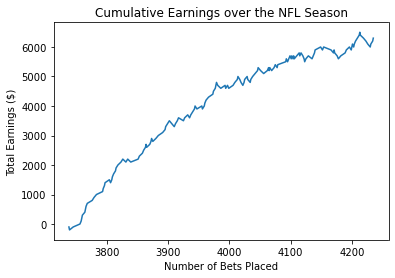

Total earnings over the NFL season: $ 6300.00


In [64]:
import matplotlib.pyplot as plt
bettable_games.loc[:, 'potential_earnings'] = bettable_games['spread_hit'] * 100 - 100 * (1 - bettable_games['spread_hit'])

# Calculate total earnings and plot a graph
total_earnings = bettable_games['potential_earnings'].sum()
cumulative_earnings = bettable_games['potential_earnings'].cumsum()

plt.plot(cumulative_earnings)
plt.title('Cumulative Earnings over the NFL Season')
plt.xlabel('Number of Bets Placed')
plt.ylabel('Total Earnings ($)')
plt.show()

# Print total earnings
print("Total earnings over the NFL season: $ {:.2f}".format(total_earnings))

### Adding stadium data

In [ ]:
#nfl_stadiums

In [ ]:
stadium_names = nfl_stadiums.iloc[:,0]
stadium_names
stadium_types = nfl_stadiums.iloc[:,7]
stadium_types

In [ ]:
stadium_types_full_col = []
for stadium in scores_df.iloc[:,11]:
    added = False
    for index in range(len(stadium_names)):
        if stadium == stadium_names[index]:
            stadium_types_full_col.append(stadium_types[index])
            added = True
    if added == False:
        stadium_types_full_col.append("NaN")
            

scores_df["stadium_type"] = stadium_types_full_col
scores_df


### Data for divisional games

In [ ]:
team_divisons = nfl_teams.iloc[:,2:6]
team_divisons_ids = nfl_teams[["team_id", "team_division"]]
team_divisons_ids.dropna(inplace = True)
team_divisons_ids = team_divisons_ids.iloc[:34]
team_divisons_ids.drop(29, inplace = True)
team_divisons_ids.drop(33, inplace = True)
team_divisons_ids

In [ ]:
divisional_game = []
for index in range(len(away_team_division_full_col)):
    if home_team_division_full_col[index] == away_team_division_full_col[index]:
        divisional_game.append(1)
    else:
        divisional_game.append(0)
        
scores_df["divisional_game"] = divisional_game
scores_df

### What team was favorite

### Game type 
1-18 week
-1 = wildcard
-2 = divisional
-3 = conference
-4 = superbowl

In [ ]:
week_type = []
for week in scores_df.iloc[:,2]:
    if week == "Wildcard":
        week_type.append(-1)
    elif week == "Division":
        week_type.append(-2)
    elif week == "Conference":
        week_type.append(-3)
    elif week == "Superbowl":
        week_type.append(-4)
    else:
        week_type.append(int(week))
scores_df["week_type"] = week_type
scores_df

Stadium Type
0 = dome
1 = warm
2 = moderate
3 = cold

In [ ]:
merged_df

In [ ]:


merged_df.dtypes

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics

In [ ]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(df.loc[:,df.columns != "spread_hit"], df.loc[:,"spread_hit"])





In [ ]:
logit_model = sm.Logit(train_labels, sm.add_constant(train_vectors))
result = logit_model.fit()
print(result.summary())